# Piston model skewness indices and Local Sobol Indices (to be renamed)

First, define model

In [1]:
import sys
sys.path.append('../')

from equadratures import *
import numpy as np
import scipy.stats as st
import sys
from collections import Counter

p_order = 5

mass = Parameter(distribution="Uniform", order = p_order, lower=30, upper=60)
area = Parameter(distribution="Uniform",order = p_order, lower=0.005, upper=0.020)
volume = Parameter(distribution="Uniform",order = p_order, lower=0.002, upper=0.010)
spring = Parameter(distribution="Uniform",order = p_order, lower=1000, upper=5000)
pressure = Parameter(distribution="Uniform",order = p_order, lower=90000, upper=110000)
ambtemp = Parameter(distribution="Uniform",order = p_order, lower=290, upper=296)
gastemp = Parameter(distribution="Uniform",order = p_order, lower=340, upper=360)

parameters = [mass, area, volume, spring, pressure, ambtemp, gastemp]

def piston(x):
    mass, area, volume, spring, pressure, ambtemp, gastemp = x[0], x[1], x[2], x[3], x[4], x[5], x[6]
    A = pressure * area + 19.62*mass - (spring * volume)/(1.0 * area)
    V = (area/(2*spring)) * ( np.sqrt(A**2 + 4*spring * pressure * volume * ambtemp/gastemp) - A)
    C = 2 * np.pi * np.sqrt(mass/(spring + area**2 * pressure * volume * ambtemp/(gastemp * V**2)))
    return C

Using poly model, calculate skewness indices

In [ ]:
orders = [p_order,p_order,p_order,p_order,p_order,p_order,p_order]
polybasis = Basis("Total order", orders)

dummy_x = np.random.uniform(size = (10000,7))
dummy_x = dummy_x * [30, .015, .008, 4000, 20000, 6, 20]
dummy_x = dummy_x + [30, .005, .002, 1000, 90000, 290, 340]

poly = Polyreg(parameters, polybasis, dummy_x, fun=piston)
overall_stats = poly.getStatistics()

fo_skew = overall_stats.getCondSkewness(1)

print fo_skew

Then, sample points for Local sobol indices...

In [3]:
total_sample_pts = 100000
extrema_fraction = 0.05
extreme_pts = int(extrema_fraction * total_sample_pts)

sample_pts = np.random.uniform(size = (total_sample_pts, 7))
sample_pts = sample_pts * [30, .015, .008, 4000, 20000, 6, 20]
sample_pts = sample_pts + [30, .005, .002, 1000, 90000, 290, 340]
sample_vals = np.apply_along_axis(piston, 1, sample_pts)
sorted_sample_vals = np.sort(sample_vals)
sorted_pts = sample_pts[np.argsort(sample_vals)]

top_vals = sorted_sample_vals[-extreme_pts:]
top_pts = sorted_pts[-extreme_pts:]
bot_vals = sorted_sample_vals[:extreme_pts]
bot_pts = sorted_pts[:extreme_pts]


Calculate correlation matrix and marginal pdfs of inputs

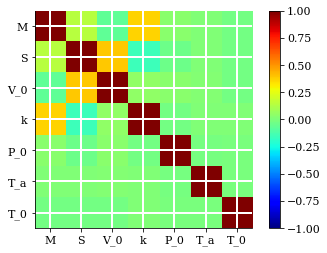

In [4]:
import matplotlib.pyplot as plt
G = np.corrcoef(top_pts.T)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(G,cmap=cm.jet, vmin=-1.0, vmax=1.0)
frame1 = plt.gca()
plt.xticks(range(0,7))
plt.yticks(range(0,7))
frame1.axes.xaxis.set_ticklabels(['M', 'S', 'V_0', 'k', 'P_0', 'T_a', 'T_0'])
frame1.axes.yaxis.set_ticklabels(['M', 'S', 'V_0', 'k', 'P_0', 'T_a', 'T_0'])
plt.colorbar()
plt.show()

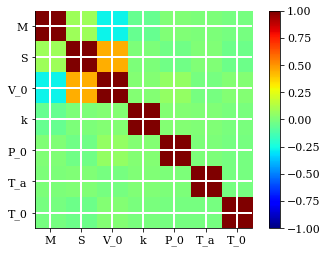

In [5]:
G = np.corrcoef(bot_pts.T)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(G,cmap=cm.jet, vmin=-1.0, vmax=1.0)
frame1 = plt.gca()
plt.xticks(range(0,7))
plt.yticks(range(0,7))
frame1.axes.xaxis.set_ticklabels(['M', 'S', 'V_0', 'k', 'P_0', 'T_a', 'T_0'])
frame1.axes.yaxis.set_ticklabels(['M', 'S', 'V_0', 'k', 'P_0', 'T_a', 'T_0'])
plt.colorbar()
plt.show()

Generate marginal PDFs for top and bottom points

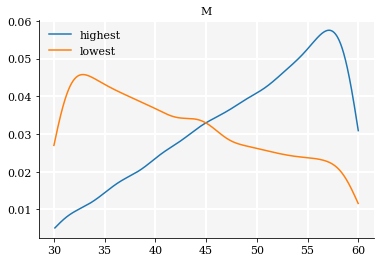

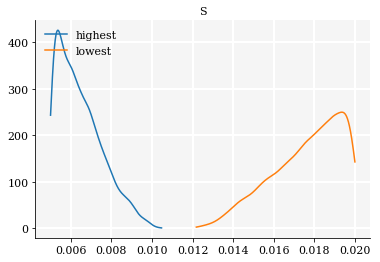

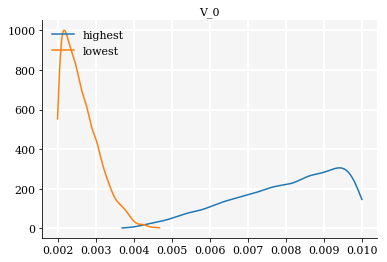

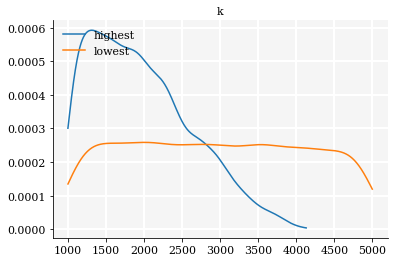

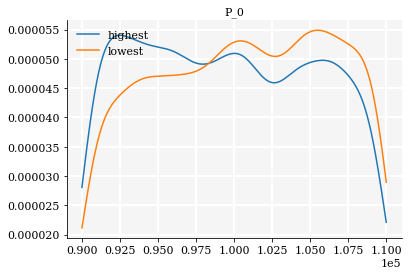

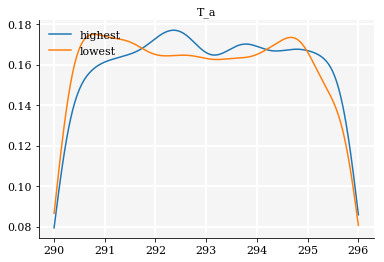

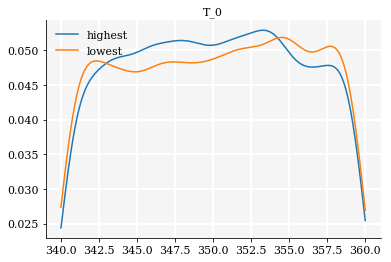

In [6]:
top_params = []
bot_params = []
names = ['M', 'S', 'V_0', 'k', 'P_0', 'T_a', 'T_0']

for i in range(7):
    top_params.append(Parameter(distribution = "Custom", order = p_order, data = top_pts[:,i]))
    bot_params.append(Parameter(distribution = "Custom", order = p_order, data = bot_pts[:,i]))
    plt.figure(i)
    plt.plot(top_params[i].getPDF(1000)[0], top_params[i].getPDF(1000)[1])
    plt.plot(bot_params[i].getPDF(1000)[0], bot_params[i].getPDF(1000)[1])
    plt.legend(['highest','lowest'], loc = 'upper left')
    plt.title(names[i])
    if i == 4:
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))


plt.show()


In [7]:
ranges = np.array([30, .015, .008, 4000, 20000, 6, 20])
top_variances = np.var(top_pts, axis = 0) /ranges**2
bot_variances = np.var(bot_pts, axis = 0) /ranges**2
print top_variances
print bot_variances

[0.06571    0.00541489 0.03064323 0.02747873 0.08383999 0.08206986
 0.08172158]
[0.08238801 0.01326978 0.00352019 0.08318268 0.08188586 0.08356588
 0.08564555]


In [8]:
import scipy.stats
stats.skew(sample_vals)

0.6174613638142036

In [9]:
top_poly_vals = poly.evaluatePolyFit(top_pts)
bot_poly_vals = poly.evaluatePolyFit(bot_pts)

top_poly_vals = np.squeeze(np.asarray(top_poly_vals))
bot_poly_vals = np.squeeze(np.asarray(bot_poly_vals))

top_C = Parameter(distribution = "Custom", order = p_order, data = top_vals)
bot_C = Parameter(distribution = "Custom", order = p_order, data = bot_vals)
top_poly_C = Parameter(distribution = "Custom", order = p_order, data = top_poly_vals)
bot_poly_C = Parameter(distribution = "Custom", order = p_order, data = bot_poly_vals)



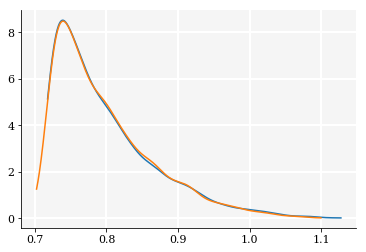

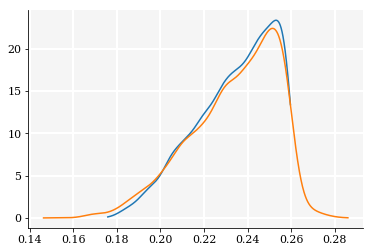

In [10]:
plt.figure(1)
plt.plot(top_C.getPDF(1000)[0], top_C.getPDF(1000)[1])
plt.plot(top_poly_C.getPDF(1000)[0], top_poly_C.getPDF(1000)[1])

plt.figure(2)
plt.plot(bot_C.getPDF(1000)[0], bot_C.getPDF(1000)[1])
plt.plot(bot_poly_C.getPDF(1000)[0], bot_poly_C.getPDF(1000)[1])

plt.show()

In [11]:
top_mass = Parameter(distribution = "Custom", order = p_order, data = top_pts[:,0])
top_area = Parameter(distribution = "Custom", order = p_order, data = top_pts[:,1])
top_vol = Parameter(distribution = "Custom", order = p_order, data = top_pts[:,2])
top_spring = Parameter(distribution = "Custom", order = p_order, data = top_pts[:,3])
top_pressure = Parameter(distribution = "Custom", order = p_order, data = top_pts[:,4])
top_ambtemp = Parameter(distribution = "Custom", order = p_order, data = top_pts[:,5])
top_gastemp = Parameter(distribution = "Custom", order = p_order, data = top_pts[:,6])
bot_mass = Parameter(distribution = "Custom", order = p_order, data = bot_pts[:,0])
bot_area = Parameter(distribution = "Custom", order = p_order, data = bot_pts[:,1])
bot_vol = Parameter(distribution = "Custom", order = p_order, data = bot_pts[:,2])
bot_spring = Parameter(distribution = "Custom", order = p_order, data = bot_pts[:,3])
bot_pressure = Parameter(distribution = "Custom", order = p_order, data = bot_pts[:,4])
bot_ambtemp = Parameter(distribution = "Custom", order = p_order, data = bot_pts[:,5])
bot_gastemp = Parameter(distribution = "Custom", order = p_order, data = bot_pts[:,6])

In [12]:
top_params = [top_mass, top_area, top_vol, top_spring, top_pressure, top_ambtemp, top_gastemp]
bot_params = [bot_mass, bot_area, bot_vol, bot_spring, bot_pressure, bot_ambtemp, bot_gastemp]

n_resample = 10000
top_resamples = np.reshape(np.array(top_mass.getSamples(m = n_resample)), (n_resample,1))
bot_resamples = np.reshape(np.array(bot_mass.getSamples(m = n_resample)), (n_resample,1))
for i in range(1,7):
    top_resamples = np.hstack([top_resamples, np.reshape(np.array(top_params[i].getSamples(m = n_resample)), (n_resample,1))])
    bot_resamples = np.hstack([bot_resamples, np.reshape(np.array(bot_params[i].getSamples(m = n_resample)), (n_resample,1))])


poly_top = Polyreg(top_params, polybasis, top_resamples, fun=piston)
poly_bot = Polyreg(bot_params, polybasis, bot_resamples, fun=piston)

In [ ]:
#poly_top = Polyreg(top_params, polybasis, top_resamples, fun=piston)
#poly_bot = Polyreg(bot_params, polybasis, bot_resamples, fun=piston)

poly_top = Polylsq(top_params, polybasis, 'random', oversampling = 1.5)
poly_bot = Polylsq(bot_params, polybasis, 'random', oversampling = 1.5)

#print poly_top.cond
#print poly_bot.cond

top_stats = poly_top.getStatistics()
bot_stats = poly_bot.getStatistics()

top_sobol = top_stats.getSobol(1)
bot_sobol = bot_stats.getSobol(1)

In [ ]:
poly_top = Polyreg(parameters, polybasis, top_pts, fun=piston)
poly_bot = Polyreg(parameters, polybasis, bot_pts, fun=piston)

top_stats = poly_top.getStatistics()
bot_stats = poly_bot.getStatistics()

top_sobol = top_stats.getSobol(1)
bot_sobol = bot_stats.getSobol(1)

#print top_sobol
#print bot_sobol

print poly_top.cond
print poly_bot.cond

It seems that the variance of the indices is quite large. Try PCA:

In [ ]:
np.set_printoptions(precision=3)
np.set_printoptions(threshold=50)
print np.corrcoef(top_pts, rowvar = False)
print np.corrcoef(bot_pts, rowvar = False)
print np.corrcoef(dummy_x, rowvar = False)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 7)
norm_top_pts = (top_pts - [30, .005, .002, 1000, 90000, 290, 340]) / [30, .015, .008, 4000, 20000, 6, 20]
pca.fit(norm_top_pts)
print(pca.explained_variance_ratio_)
print(pca.components_)

In [ ]:
import SALib
from SALib.sample import saltelli
problem = {'num_vars': 7,
    'names': ['mass', 'area', 'volume', 'spring', 'pressure', 'ambtemp', 'gastemp'],
    'bounds': [[30, 60],
               [0.005, 0.020],
               [0.002, 0.010],
              [1000, 5000],
               [90000, 110000],
               [290, 296],
              [340,360]]
}
param_values = saltelli.sample(problem, 1000)
sample_vals = np.apply_along_axis(piston, 1, param_values)
S = sobol.analyze(problem, sample_vals, print_to_console=True)


# But cannot use own sampling!

In [ ]:
top_vals.shape
